# Training Reproducibility with tensorflow

## 1 - Import the required Python modules

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppress the numerous TensorFlow warnings

import tensorflow as tf
from tensorflow import keras

import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# specific modules:
from utils.tools import scan_dir, plot_images, plot_loss_accuracy, elapsed_time_since, show_conf_matrix, plot_proportion_bar

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} with keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.12.3
tensorflow: 2.16.2 with keras 3.8.0
numpy     : 1.26.4
OpenCV    : 4.11.0


In [2]:
# allows to visualize the graphs directly in the cell of the notebook:
%matplotlib inline

Set the seed if needed, for all the random generators:

In [3]:
SEED = 1234

## 2 - Load the MNIST dataset (images and labels)

We use the keras `load_data` function to load the data from the MNIST 
(see [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data)):<br>
- `im_train`, `lab_train` are the training images and labels,
- `im_valid`, `lab_valid` are the validation images and labels.

In [4]:
(im_train, lab_train), (im_valid, lab_valid) = keras.datasets.mnist.load_data()

Let's check the `shape` and `dtype` attributes of the numpy arrays:

In [5]:
print(f"im_train.shape:  {im_train.shape}, dtype: {im_train.dtype}")
print(f"im_valid.shape:  {im_valid.shape}, dtype: {im_valid.dtype}")
print(f"lab_train.shape: {lab_train.shape}, dtype: {lab_train.dtype}")
print(f"lab_vaild.shape: {lab_valid.shape}, dtype: {lab_valid.dtype}")

im_train.shape:  (60000, 28, 28), dtype: uint8
im_valid.shape:  (10000, 28, 28), dtype: uint8
lab_train.shape: (60000,), dtype: uint8
lab_vaild.shape: (10000,), dtype: uint8


### Reduce the size of the dataset

For demonstration purposes, we will truncate the input arrays to 1/10 of the initial sizes:

In [6]:
im_train  = im_train[:6000]
lab_train = lab_train[:6000]
im_valid  = im_valid[:1000]
lab_valid = lab_valid[:1000]

print("im_train.shape :", im_train.shape, ", lab_train.shape:", lab_train.shape)
print("im_valid.shape :", im_valid.shape, ", lab_valid.shape:", lab_valid.shape)

im_train.shape : (6000, 28, 28) , lab_train.shape: (6000,)
im_valid.shape : (1000, 28, 28) , lab_valid.shape: (1000,)


### Visualization of images and labels:

The local module `utils.tools` defines the `plot_images` function which can be used to diplay a grid of MINIT images.<br>
Let's plot a grid of images 4 x 6 geginning with the 600th image:

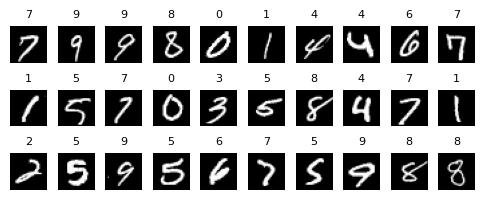

In [7]:
plot_images(im_train, 3, 10, 599, label_array=lab_train)

### Create the 3 datasets: tain, validation & test

To follow the _state of the art_, we will split the whole dataset into train, validation & test datasets.<br>
A simple way to do this is to keep the train dataset and to split of the current validation dataset in two equal subsets:
- a new smaller validation set,
- a new test set.

In [8]:
# note on train_test_split : Stratified train/test split is not implemented for shuffle=False 

im_valid, im_test, lab_valid, lab_test = train_test_split(im_valid, lab_valid,
                                                          stratify=lab_valid,
                                                          test_size=0.5,
                                                          shuffle=True,
                                                          random_state=SEED)

We can verify that the proportion of digits remains homogenous in all the datasets:

In [9]:
prop = {}
prop['valid'] = [ (lab_valid == i).sum() for i in range(10)]
prop['test']  = [ (lab_test  == i).sum() for i in range(10)]

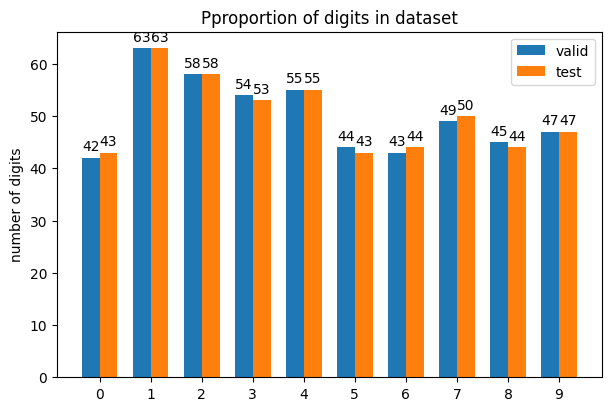

In [10]:
plot_proportion_bar(prop, range(10))

### Setting useful parameters:

To avoid hard-coding the number of training and test images as well as the size of the images, these parameters are recovered from the data set:
- with the shape attribute of the image arrays
- with the size attribute of the first training image for example

In [11]:
# number of training images:
NB_IM_TRAIN = im_train.shape[0]
NB_IM_VALID = im_valid.shape[0]     
NB_IM_TEST  = im_test.shape[0]     

# number of elements (pixels) of the firts training image: 
NB_PIXEL    = im_train[0].size   

# Visual checking:
print(f"Image size: {im_train.shape[1]}x{im_train.shape[2]}={NB_PIXEL} pixels")

# number of classes:
NB_CLASS = len(set(lab_train))
print(f"{NB_CLASS} different classes found in the `lab_train` ndarray")

Image size: 28x28=784 pixels
10 different classes found in the `lab_train` ndarray


## 3 - Pre-process input dataset

### Reshape the data arrays to fit keras requirements

The convolutional layers of **keras** take by default arrays of shape `(batch_size, height, width, depth)` :
- `batch_size` : umber of images in a batch of input date,
- `height` et `width` : the size of the images in pixels,
- `depth` : color dimension (`3` for a RGB image, `1` for a grey tone image).

The current shapes of the input arrays ares :

In [12]:
im_train.shape, im_valid.shape, im_test.shape

((6000, 28, 28), (500, 28, 28), (500, 28, 28))

We must add the dimension `depth` (value: 1 for grey tone images) after the third dimension `width`, for example using the method `reshape` of the class `ndarray`.<br>
We also normalize the input arrays so that their elements are in [0, 1]. 

In [13]:
x_train = im_train.reshape(im_train.shape + (1,))/255
x_valid = im_valid.reshape(im_valid.shape + (1,))/255
x_test  = im_test.reshape(im_test.shape + (1,))/255

check:

In [14]:
# check:
print(f'train:  {im_train.shape} -> {x_train.shape},  min: {x_train.min()}, max: {x_train.max()}')
print(f'valid:  {im_valid.shape} -> {x_valid.shape},  min: {x_valid.min()}, max: {x_valid.max()}')
print(f'test :  {im_test.shape}  -> {x_test.shape},  min: {x_test.min()}, max: {x_test.max()}')

train:  (6000, 28, 28) -> (6000, 28, 28, 1),  min: 0.0, max: 1.0
valid:  (500, 28, 28) -> (500, 28, 28, 1),  min: 0.0, max: 1.0
test :  (500, 28, 28)  -> (500, 28, 28, 1),  min: 0.0, max: 1.0


### *one-hot* encoding of the label arrays:

We use the **keras** `to_categorical` function (see [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)) to define the `y_train`, `y_valid` and `y_test` arrays containing the *hot-one* encoded version of `lab_train`, `lab_valid` and `lab_test`:

In [15]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of labels :
y_train = to_categorical(lab_train)
y_valid = to_categorical(lab_valid)
y_test  = to_categorical(lab_test)

Let's check the first 10 values of the `lab_train` and `y_train` arrays:

In [16]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## 4 - Build the Convolutional Neural Network (CNN)

We build a CNN similar to __LeNet5__ introduced in the research paper “Gradient-Based Learning Applied To Document Recognition” in 1998 by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffnerfrom.

![img/LeNet5.png](img/LeNet5.png)

In the rest of this notebook, we will build the CNN many times so we define the function `build_CNN`:

In [17]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D, MaxPool2D, Flatten

def build_CNN(input_shape, seed=None):

    if seed != None:
        # Deterministic tensorflow training: 
        # 1/ set the seed of the random generators involved with tensorflow:
        tf.keras.utils.set_random_seed(seed)
        # 2/ make the tf aps determinisctic 
        # [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
        tf.config.experimental.enable_op_determinism()         
    
    model = Sequential(name='LeNet5')
    
    # A layer to give the 4 dimensions of the input data:
    model.add(Input(shape=input_shape))
    
    # Layer C1: 6 convolution filters of 5x5 with padding and 'relu' activation function:
    model.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', name='C1'))
    
    # Layer S2: 'maximum' poolling stage, with 2x2:
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='S2'))
    
    # Layer C3: 16 convolution filters of 5x5 with padding and 'relu' activation function:
    model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu', name='C3'))
    
    # Layer S4: 'maximum' poolling stage, with 2x2:
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='S4'))
    
    # Flatten the images into a single vector with all the pixels:
    model.add(Flatten())

    # Layer C5: dense layer with 120 neurons and 'relu' activation function:
    model.add(Dense(120, activation='relu', name='C5'))
    
    # F6: dense layer with 84 neurones and 'relu' activation function:
    model.add(Dense(84, activation='relu', name='F6'))
    
    # Output: final dense layer, with 'NB_CLASS'(10) neutones and the 'softmax' 
    # activation function dedicated to classification training:
    model.add(Dense(NB_CLASS, activation='softmax', name='Output'))    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

### Save the initial state of the network (structure & data)

We can save the weights of the initial CNN (random values) and its structure with the `model.save` method. <br>
This will be useful later to re-create the CNN to its initial state if we want to compare different trainings:

In [18]:
import os

# Build one instance of the CNN,  without setting any seed:
model = build_CNN(x_train[0].shape)

# Check wether the 'model' exist and create it if not:
if not os.path.isdir("models"): os.mkdir("models")

# save the structure and the initial waights of the network:
model_file = 'model_initial_noseed.keras'
model.save('models/' + model_file)

# display the files
files=[os.path.join("models",f) for f in os.listdir("models") if f.endswith('.keras')]
for f in files: print(f)

models/model_initial_noseed.keras


In [19]:
model.summary()

Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2 (MaxPooling2D)               │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4 (MaxPooling2D)               │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C5 (Dense)                      │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

## 5 - Train the CNN...

### A first training... to see

 Elapsed time 3s -> 00:00:03


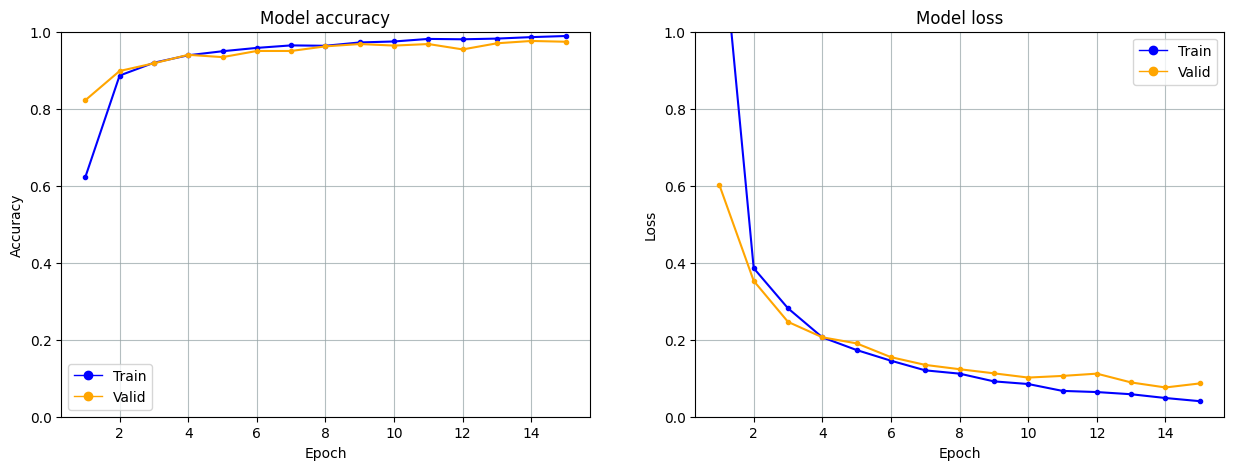

In [21]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=15,      # the total number of successive trainings
                 batch_size=128,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
print(elapsed_time_since(t0))
plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

### Retry the training : non reproducibility revealed

 Elapsed time 3s -> 00:00:03


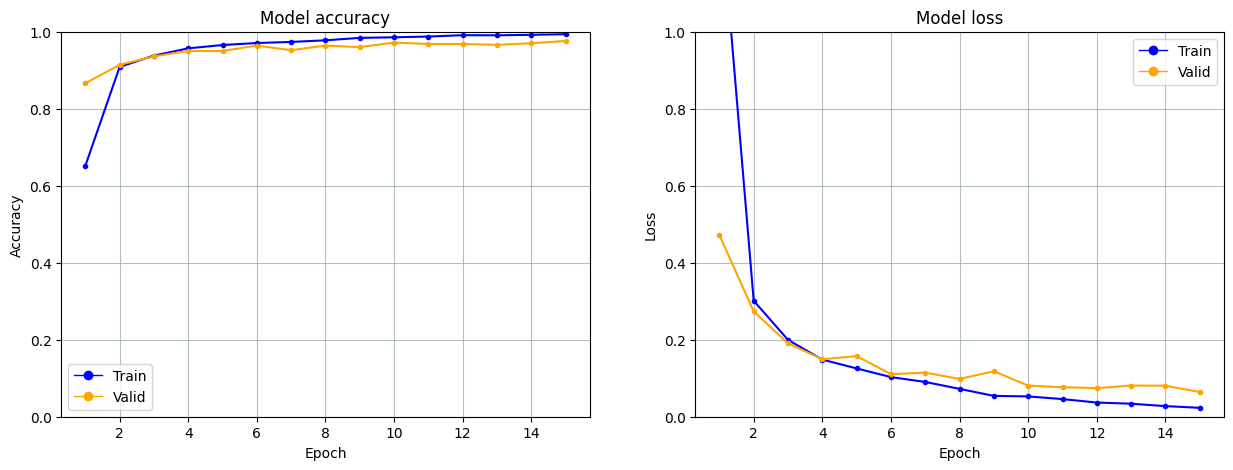

In [22]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=15,      # the total number of successive trainings
                 batch_size=128,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
print(elapsed_time_since(t0))
plot_loss_accuracy(hist, min_acc=0., max_loss=1, single_color=False)   

### Running several identical trainings to compare their _Validation loss_ curves

#1  Elapsed time 15s -> 00:00:15
#2  Elapsed time 15s -> 00:00:15
#3  Elapsed time 15s -> 00:00:15
#4  Elapsed time 15s -> 00:00:15
#5  Elapsed time 15s -> 00:00:15
#6  Elapsed time 15s -> 00:00:15


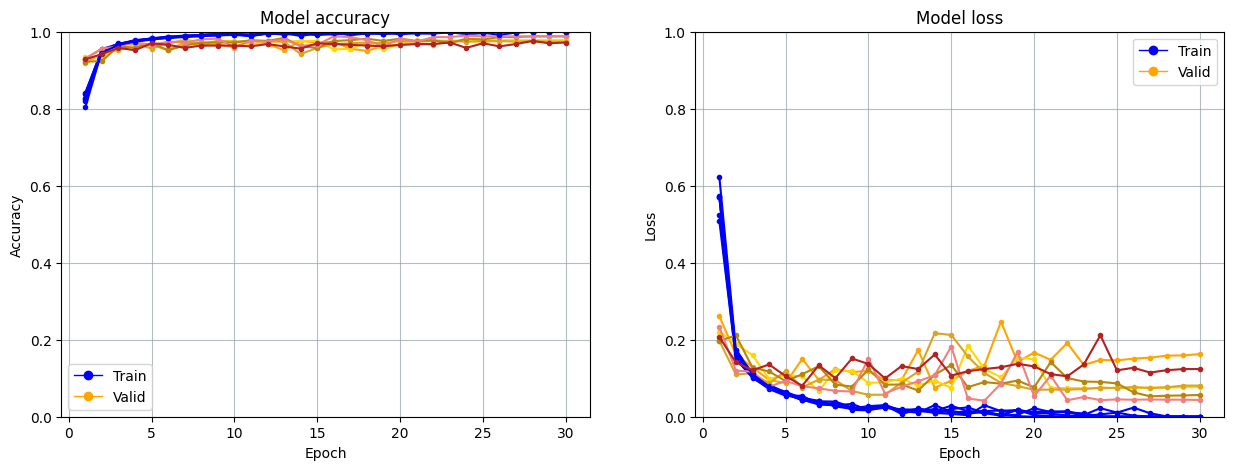

In [23]:
from time import time

H = []
for i in range(6):
    print(f'#{i+1}', end='')
    
    # Build a new model at each lopp lap, without setting the tf seed:
    model = build_CNN(x_train[0].shape, seed=None)
        
    t0 = time()
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=30,        # the total number of successive trainings
                     batch_size=16,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    print(f'\r#{i+1} {elapsed_time_since(t0)}')
    H.append(hist)  
    
plot_loss_accuracy(H, min_acc=0., max_acc=1, min_loss=0, max_loss=1, single_color=False)   

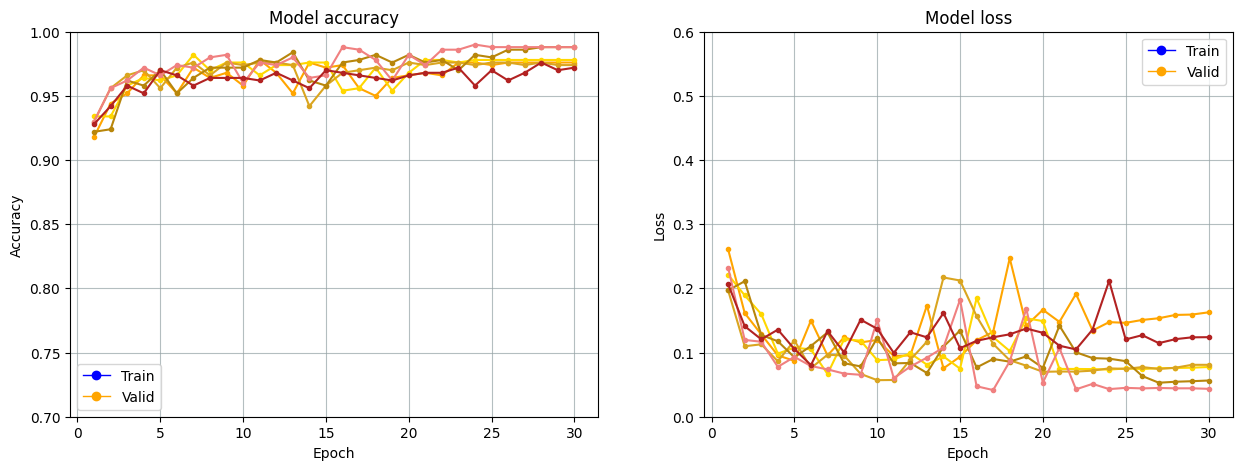

In [25]:
plot_loss_accuracy(H, training=False, single_color=False, min_acc=0.7,max_acc=1, min_loss=0, max_loss=.6,  max_epoch=30)   

### Running several identical training with __reproducibility setting validated__

Now we will try the same training but with setting the SEDD

Using:
"tf.keras.utils.set_random_seed(1234)"
"tf.config.experimental.enable_op_determinism()"
to ensure training reproducibility
#1  Elapsed time 30s -> 00:00:30
#2  Elapsed time 26s -> 00:00:26
#3  Elapsed time 25s -> 00:00:25
#4  Elapsed time 25s -> 00:00:25
#5  Elapsed time 24s -> 00:00:24
#6  Elapsed time 25s -> 00:00:25


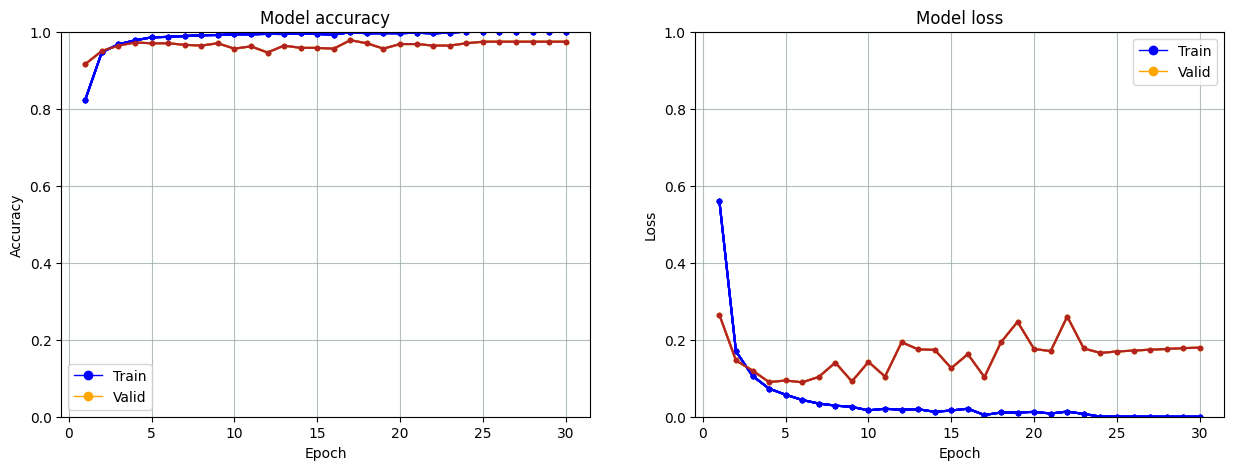

In [26]:
from time import time

print(f'Using:\n"tf.keras.utils.set_random_seed({SEED})"\n"tf.config.experimental.enable_op_determinism()"\nto ensure training reproducibility')
H = []
for i in range(6):
    print(f'#{i+1}', end='')
    
    # Build a new model at each lopp lap, with setting the tf seed:
    model = build_CNN(x_train[0].shape, seed=SEED)
        
    t0 = time()
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=30,        # the total number of successive trainings
                     batch_size=16,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    print(f'\r#{i+1} {elapsed_time_since(t0)}')
    H.append(hist)  
    
plot_loss_accuracy(H, min_acc=0., max_acc=1, min_loss=0, max_loss=1, single_color=False)   

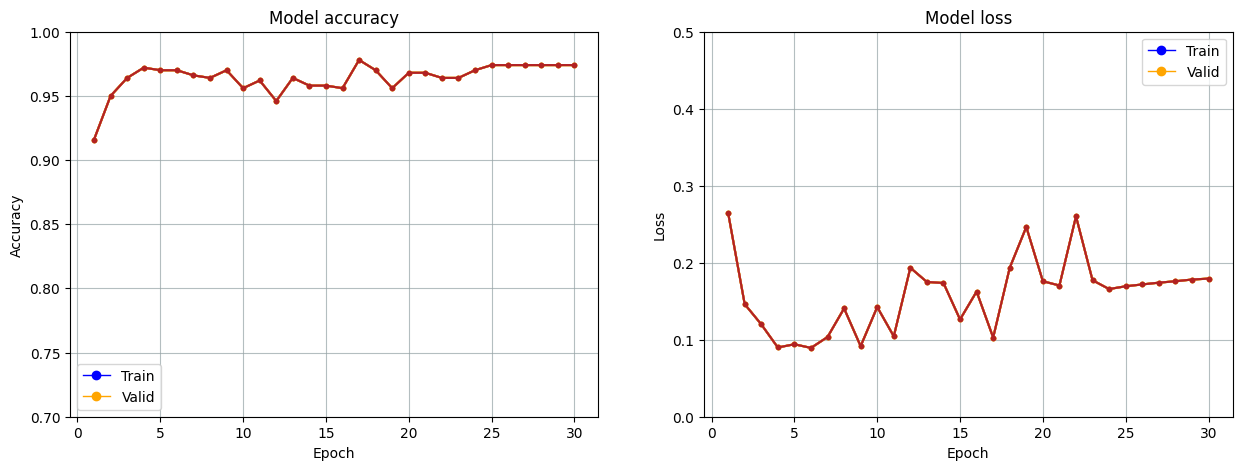

In [27]:
plot_loss_accuracy(H, training=False, single_color=False, min_acc=0.7,max_acc=1, min_loss=0, max_loss=.5,  max_epoch=30)   

In [28]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Predicting labels for test images
predict_labels = np.argmax(model.predict(x_test), axis=-1)

# Display classification report
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=-1), predict_labels))

16/16 - 0s - 5ms/step - accuracy: 0.9800 - loss: 0.0979
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      1.00      1.00        63
           2       0.98      0.97      0.97        58
           3       1.00      1.00      1.00        53
           4       1.00      0.96      0.98        55
           5       0.98      1.00      0.99        43
           6       0.98      0.98      0.98        44
           7       0.96      0.96      0.96        50
           8       0.98      0.98      0.98        44
           9       0.94      0.96      0.95        47

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



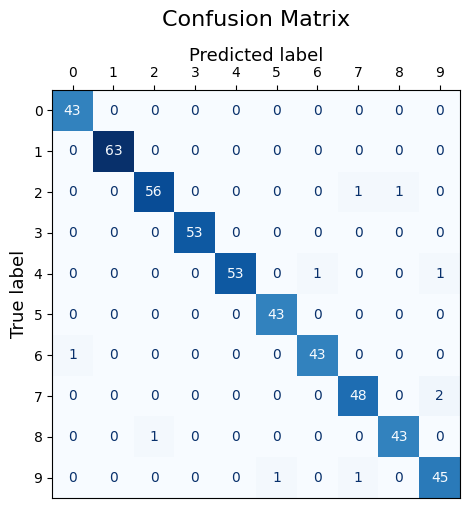

In [29]:
show_conf_matrix(lab_test, predict_labels, range(NB_CLASS), figsize=(7,6))

### Running several identical training with reloading the initial state

Another way to ensure reproductibility is to reload the model structure and initial weights at each run:

#1

/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Study-01/.venv/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(
/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Study-01/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#1  Elapsed time 27s -> 00:00:27
#2  Elapsed time 24s -> 00:00:24
#3  Elapsed time 23s -> 00:00:23
#4  Elapsed time 25s -> 00:00:25
#5  Elapsed time 25s -> 00:00:25
#6  Elapsed time 25s -> 00:00:25


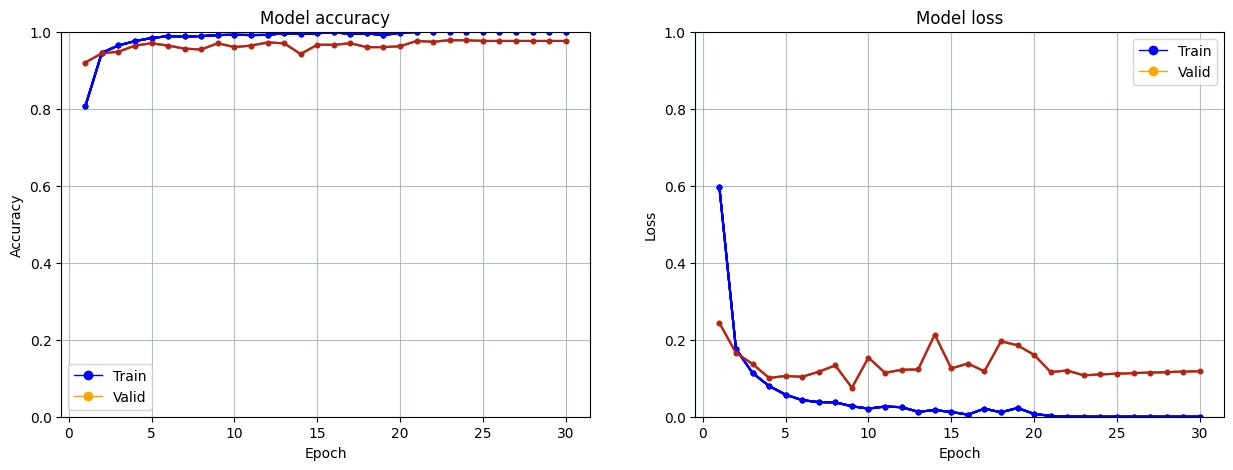

In [30]:
from time import time

# Deterministic tensorflow training: 
# 1/ set the seed of the random generators involved with tensorflow:
tf.keras.utils.set_random_seed(SEED)
# 2/ make the tf aps determinisctic 
# [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
tf.config.experimental.enable_op_determinism()        

H = []
for i in range(6):
    print(f'#{i+1}', end='')

    # save the structure and the initial waights of the network:
    model_file = 'model_initial_noseed.keras'

    # load the network structure & initial weights:
    model = tf.keras.models.load_model('models/' + model_file)
        
    t0 = time()
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=30,        # the total number of successive trainings
                     batch_size=16,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    print(f'\r#{i+1} {elapsed_time_since(t0)}')
    H.append(hist)  
    
plot_loss_accuracy(H, min_acc=0., max_acc=1, min_loss=0, max_loss=1, single_color=False)   

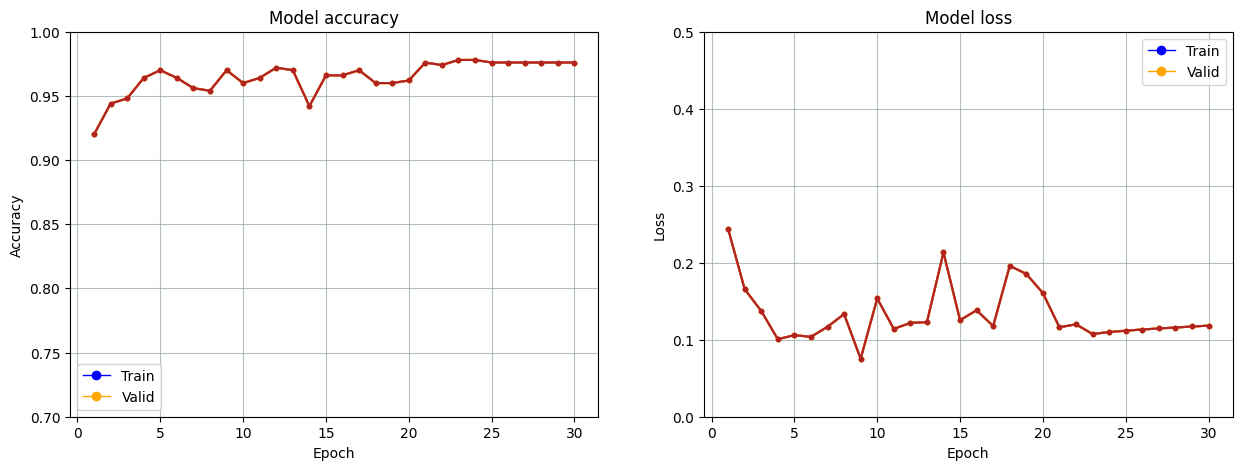

In [31]:
plot_loss_accuracy(H, training=False, single_color=False, min_acc=0.7,max_acc=1, min_loss=0, max_loss=.5,  max_epoch=30)   

In [32]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Predicting labels for test images
predict_labels = np.argmax(model.predict(x_test), axis=-1)

# Display classification report
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=-1), predict_labels))

16/16 - 0s - 3ms/step - accuracy: 0.9920 - loss: 0.0710
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      1.00      1.00        63
           2       0.98      1.00      0.99        58
           3       0.98      1.00      0.99        53
           4       1.00      0.98      0.99        55
           5       1.00      0.98      0.99        43
           6       1.00      0.98      0.99        44
           7       1.00      1.00      1.00        50
           8       1.00      0.98      0.99        44
           9       0.98      1.00      0.99        47

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



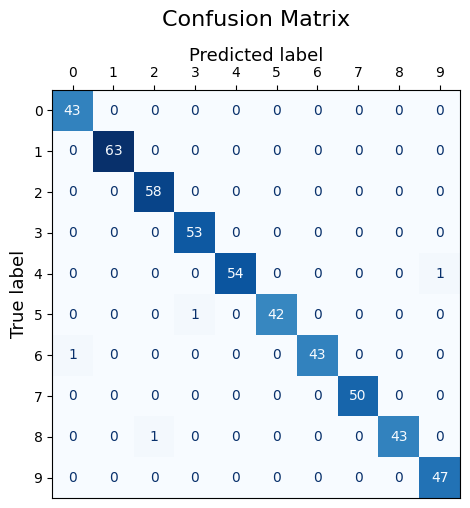

In [33]:
show_conf_matrix(lab_test, predict_labels, range(NB_CLASS), figsize=(7,6))

## 6 - Autres ressources intéressantes... des vidéos :

In [33]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [34]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [35]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [36]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>